# ✅ Load & Evaluate Saved TradeTransformer Model

In [1]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset, DataLoader
import ta
import os
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# 🧠 Define the model class again (must match the architecture used before)

In [2]:
class TimeSeriesTransformer(torch.nn.Module):
    def __init__(self, input_dim, seq_length, pred_length):
        super().__init__()
        self.d_model = 64
        self.input_fc = torch.nn.Linear(input_dim, self.d_model)
        self.pos_embedding = torch.nn.Parameter(torch.zeros(1, seq_length, self.d_model))
        encoder_layer = torch.nn.TransformerEncoderLayer(d_model=self.d_model, nhead=8, dim_feedforward=256, batch_first=True)
        self.encoder = torch.nn.TransformerEncoder(encoder_layer, num_layers=2)
        self.price_head = torch.nn.Linear(self.d_model, pred_length)
        self.class_head = torch.nn.Linear(self.d_model, 1)

    def forward(self, x):
        x = self.input_fc(x) + self.pos_embedding[:, :x.size(1), :]
        x = self.encoder(x)
        last_step = x[:, -1, :]
        return self.price_head(last_step), self.class_head(last_step).squeeze(-1)


# 📂 Load model

In [4]:
model = TimeSeriesTransformer(input_dim=18, seq_length=60, pred_length=1)
model.load_state_dict(torch.load("../Models/trained_trade_transformer.pth", map_location='cpu'))
model.eval()


TimeSeriesTransformer(
  (input_fc): Linear(in_features=18, out_features=64, bias=True)
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
        )
        (linear1): Linear(in_features=64, out_features=256, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=256, out_features=64, bias=True)
        (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (price_head): Linear(in_features=64, out_features=1, bias=True)
  (class_head): Linear(in_features=64, out_features=1, bias=True)
)

# 🧪 Data Preparation Helpers

In [5]:
def add_technical_indicators(df):
    df['rsi'] = ta.momentum.rsi(df['Close'], window=14)
    bb = ta.volatility.BollingerBands(df['Close'], window=20, window_dev=2)
    df['bb_high'] = bb.bollinger_hband()
    df['bb_low'] = bb.bollinger_lband()
    df['ma_20'] = df['Close'].rolling(20).mean()
    df['ma_20_slope'] = df['ma_20'].diff()
    df['macd'] = ta.trend.macd_diff(df['Close'])
    df['ema_12'] = ta.trend.ema_indicator(df['Close'], window=12)
    df['ema_26'] = ta.trend.ema_indicator(df['Close'], window=26)
    df['atr'] = ta.volatility.average_true_range(df['High'], df['Low'], df['Close'])
    df['adx'] = ta.trend.adx(df['High'], df['Low'], df['Close'])
    df['cci'] = ta.trend.cci(df['High'], df['Low'], df['Close'])
    df['obv'] = ta.volume.on_balance_volume(df['Close'], df['Volume'])
    df['Ticker_ID'] = 0
    df.fillna(method='bfill', inplace=True)
    df.fillna(method='ffill', inplace=True)
    return df


In [6]:
def prepare_data(csv_file):
    df = pd.read_csv(csv_file, delimiter='\t')
    df.columns = df.columns.str.strip()
    df['Gmt time'] = pd.to_datetime(df['Gmt time'], format='%d.%m.%Y %H:%M:%S.%f')
    df = add_technical_indicators(df)
    feature_cols = ['Open', 'High', 'Low', 'Close', 'Volume', 'rsi', 'bb_high', 'bb_low', 'ma_20',
                    'ma_20_slope', 'macd', 'ema_12', 'ema_26', 'atr', 'adx', 'cci', 'obv', 'Ticker_ID']
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(df[feature_cols])
    return df, scaled, scaler, feature_cols


# 📊 Full Evaluation

In [10]:
def enhanced_evaluation(model, df, data_scaled, scaler, feature_cols, seq_length=60, pred_length=1):
    target_idx = feature_cols.index('Close')
    real_prices = []
    predicted_prices = []
    timestamps = []

    for i in range(len(data_scaled) - seq_length - pred_length):
        x = data_scaled[i:i+seq_length]
        y = data_scaled[i+seq_length:i+seq_length+pred_length, target_idx]
        x_tensor = torch.tensor(x, dtype=torch.float32).unsqueeze(0)
        pred, _ = model(x_tensor)
        dummy_pred = np.zeros((pred_length, len(feature_cols)))
        dummy_pred[:, target_idx] = pred.detach().numpy()[0]
        dummy_real = np.zeros((pred_length, len(feature_cols)))
        dummy_real[:, target_idx] = y
        predicted_prices.extend(scaler.inverse_transform(dummy_pred)[:, target_idx])
        real_prices.extend(scaler.inverse_transform(dummy_real)[:, target_idx])
        timestamps.append(df['Gmt time'].iloc[i+seq_length])

    # Metrics
    real_prices = np.array(real_prices)
    predicted_prices = np.array(predicted_prices)
    mse = mean_squared_error(real_prices, predicted_prices)
    mae = mean_absolute_error(real_prices, predicted_prices)
    r2 = r2_score(real_prices, predicted_prices)
    mape = np.mean(np.abs((real_prices - predicted_prices) / real_prices)) * 100
    
    direction_accuracy = np.mean(np.sign(np.diff(predicted_prices)) == np.sign(np.diff(real_prices))) * 100

    print("\n📊 Evaluation Metrics:")
    print(f"  • MSE   : {mse:.4f}")
    print(f"  • MAE   : {mae:.4f}")
    print(f"  • R^2   : {r2:.4f}")
    print(f"  • MAPE  : {mape:.2f}%")
    print(f"  • Directional Accuracy: {direction_accuracy:.2f}%")

    # 💰 Simulated Trading: Predicted Direction
    returns = np.diff(real_prices)
    strategy = np.sign(np.diff(predicted_prices)) * returns
    cumulative_real = np.cumsum(returns)
    cumulative_strategy = np.cumsum(strategy)

    plt.figure(figsize=(12, 6))
    plt.plot(cumulative_real, label='Buy & Hold (Actual Returns)')
    plt.plot(cumulative_strategy, label='Strategy (Predicted Direction)')
    plt.title("📈 Cumulative Returns Simulation")
    plt.xlabel("Time Step")
    plt.ylabel("Cumulative Return")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # 💸 Show monthly and daily PnL if timestamps exist
    pnl_df = pd.DataFrame({
        'timestamp': timestamps[1:],
        'strategy_return': strategy,
        'actual_return': returns
    })
    pnl_df['date'] = pd.to_datetime(pnl_df['timestamp'])
    pnl_df.set_index('date', inplace=True)

    monthly = pnl_df[['strategy_return']].resample('M').sum()
    daily = pnl_df[['strategy_return']].resample('D').sum()

    print("\n📅 Monthly Strategy PnL:")
    print(monthly['strategy_return'].round(2))

    print("\n📅 Daily Strategy PnL (last 7 days):")
    print(daily['strategy_return'].tail(7).round(2))

    return real_prices, predicted_prices


/tmp/ipykernel_11331/3466033394.py:16: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipykernel_11331/3466033394.py:17: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)



📊 Evaluation Metrics:
  • MSE   : 10.0249
  • MAE   : 2.0512
  • R^2   : 0.9828
  • MAPE  : 1.00%
  • Directional Accuracy: 48.55%


/tmp/ipykernel_11331/3043348121.py:51: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/varun/Desktop/someProj/TradeGPT/.venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


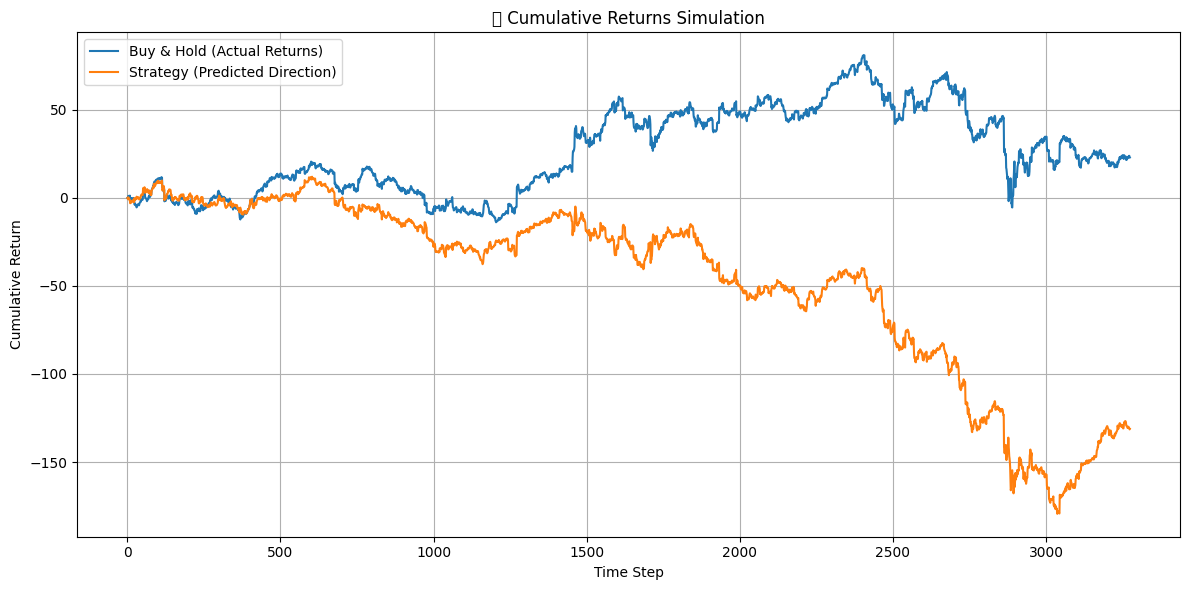


📅 Monthly Strategy PnL:
date
2023-08-31     8.26
2023-09-30   -10.85
2023-10-31    -4.90
2023-11-30     9.21
2023-12-31     1.07
2024-01-31    -8.05
2024-02-29   -11.79
2024-03-31   -14.33
2024-04-30     4.64
2024-05-31    17.15
2024-06-30    -9.31
2024-07-31   -14.24
2024-08-31    15.84
2024-09-30   -23.62
2024-10-31    -8.99
2024-11-30    -0.62
2024-12-31    -2.40
2025-01-31   -28.50
2025-02-28    -8.66
2025-03-31   -29.52
2025-04-30   -38.32
2025-05-31     8.99
2025-06-30    17.80
Freq: ME, Name: strategy_return, dtype: float64

📅 Daily Strategy PnL (last 7 days):
date
2025-06-21    0.00
2025-06-22    0.00
2025-06-23   -1.59
2025-06-24    0.30
2025-06-25    2.31
2025-06-26   -3.24
2025-06-27   -0.58
Freq: D, Name: strategy_return, dtype: float64


/tmp/ipykernel_11331/3043348121.py:63: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly = pnl_df[['strategy_return']].resample('M').sum()


In [11]:
# ✅ Run Evaluation
csv_file = "../Output/formatted_data_1h/AAPL_1h_data.csv"
df, data_scaled, scaler, feature_cols = prepare_data(csv_file)
real, pred = enhanced_evaluation(model, df, data_scaled, scaler, feature_cols)


In [12]:
import numpy as np

returns = np.array([8.26, -10.85, -4.90, 9.21, 1.07, -8.05, -11.79, -14.33, 4.64,
                    17.15, -9.31, -14.24, 15.84, -23.62, -8.99, -0.62, -2.40,
                    -28.50, -8.66, -29.52, -38.32, 8.99, 17.80])

cumulative = np.prod(1 + returns / 100) - 1
print(f"Cumulative Return: {cumulative:.2%}")


Cumulative Return: -80.89%
